In [1]:
pip install pandas numpy gensim scikit-learn


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import gensim
from gensim.models import Word2Vec
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.model_selection import train_test_split

In [4]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Imdbdataset.csv')

In [6]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [7]:

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
import re

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Imdbdataset.csv')

# Display the first few rows of the dataframe
print(df.head())

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Basic cleaning function to remove HTML tags, special characters, and make everything lowercase
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove special characters
    text = text.lower()  # Lowercase text
    text = text.strip()  # Remove leading and trailing whitespace
    return text

# Apply the cleaning function to the review column
df['cleaned_review'] = df['review'].apply(clean_text)

# Display a few cleaned reviews
print(df[['review', 'cleaned_review']].head())

# Check for errors (e.g., empty reviews after cleaning)
errors = df[df['cleaned_review'].apply(lambda x: len(x) == 0)]
print("Rows with errors (empty reviews):\n", errors)

# Calculate mean length of reviews
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
print("Mean review length:", df['review_length'].mean())

# Tokenize the cleaned reviews
df['tokens'] = df['cleaned_review'].apply(lambda x: x.split())

# Split the dataset into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Train a Word2Vec model on the tokenized reviews
w2v_model = Word2Vec(sentences=train['tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Function to average Word2Vec vectors for a document
def average_word2vec(tokens, model, num_features):
    feature_vec = np.zeros((num_features,), dtype='float32')
    n_words = 0
    index2word_set = set(model.wv.index_to_key)
    for word in tokens:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Create feature vectors for train and test sets
train_vectors = train['tokens'].apply(lambda x: average_word2vec(x, w2v_model, 100))
test_vectors = test['tokens'].apply(lambda x: average_word2vec(x, w2v_model, 100))

# Convert lists to numpy arrays
train_vectors = np.array(train_vectors.tolist())
test_vectors = np.array(test_vectors.tolist())

# Display the shape of the resulting feature vectors
print("Training vectors shape:", train_vectors.shape)
print("Testing vectors shape:", test_vectors.shape)


                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Missing values per column:
 review       0
sentiment    0
dtype: int64
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one of the other reviewers has mentioned that ...  
1  a wonderful little production the filming tech...  
2  i thought this was a wonderful way to spend ti

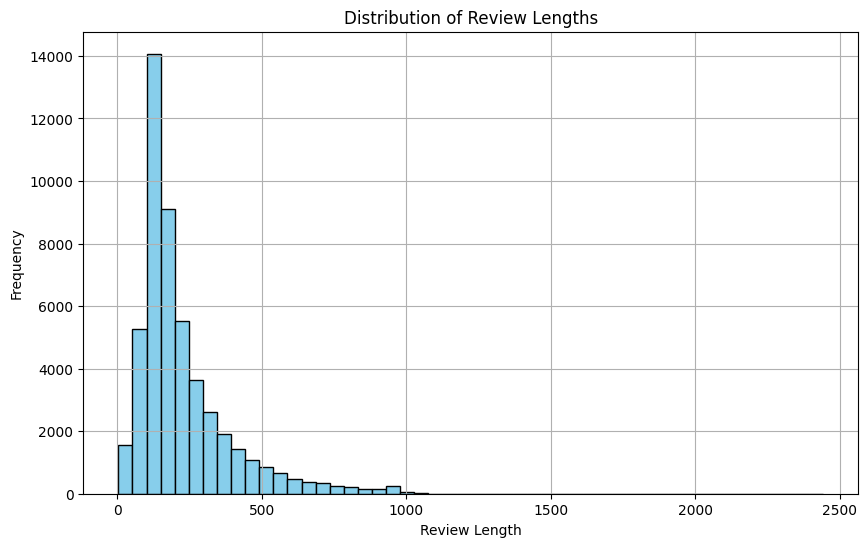

In [10]:
import matplotlib.pyplot as plt

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
plt.hist(df['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


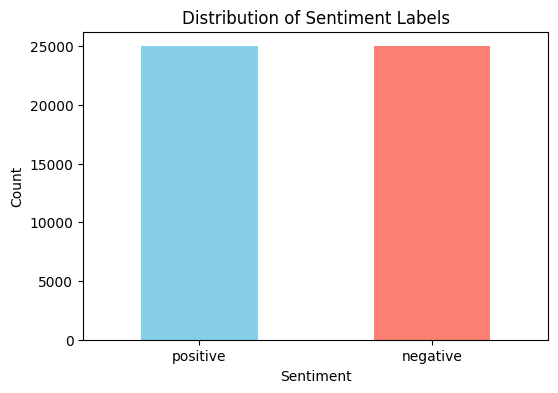

In [11]:
# Plot the distribution of sentiment labels
plt.figure(figsize=(6, 4))
df['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()
#This plot can help you ensure that your dataset is balanced between positive and negative sentiment
#labels. If there is a severe imbalance, it may affect the model's performance.

In [12]:
# Check the balance of the dataset
sentiment_counts = df['sentiment'].value_counts()
print("Sentiment counts:\n", sentiment_counts)


Sentiment counts:
 sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [13]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re
# Split the dataset into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Train a Word2Vec model on the tokenized reviews
w2v_model = Word2Vec(sentences=train['tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Function to average Word2Vec vectors for a document
def average_word2vec(tokens, model, num_features):
    feature_vec = np.zeros((num_features,), dtype='float32')
    n_words = 0
    index2word_set = set(model.wv.index_to_key)
    for word in tokens:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Create feature vectors for train and test sets
train_vectors = train['tokens'].apply(lambda x: average_word2vec(x, w2v_model, 100))
test_vectors = test['tokens'].apply(lambda x: average_word2vec(x, w2v_model, 100))

# Convert lists to numpy arrays
train_vectors = np.array(train_vectors.tolist())
test_vectors = np.array(test_vectors.tolist())

# Encode the sentiment labels
train_labels = train['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
test_labels = test['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(train_vectors, train_labels)

# Make predictions
predictions = model.predict(test_vectors)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
conf_matrix = confusion_matrix(test_labels, predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8446
Precision: 0.8384
Recall: 0.8567
F1 Score: 0.8475
Confusion Matrix:
[[4129  832]
 [ 722 4317]]


In [19]:
input = "A wonderful little production"
input = average_word2vec(input, w2v_model, 100)
predicted_value = model.predict([input])
print(predicted_value)
res= "negative" if predicted_value[0]==1 else 'positive'
print(res)

[0]
positive


In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import re

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Imdbdataset.csv')

# Display the first few rows of the dataframe
print(df.head())

# Check for missing values
print("Missing values per column:\n", df.isnull().sum())

# Basic cleaning function to remove HTML tags, special characters, and make everything lowercase
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove special characters
    text = text.lower()  # Lowercase text
    text = text.strip()  # Remove leading and trailing whitespace
    return text

# Apply the cleaning function to the review column
df['cleaned_review'] = df['review'].apply(clean_text)

# Display a few cleaned reviews
print(df[['review', 'cleaned_review']].head())

# Check for errors (e.g., empty reviews after cleaning)
errors = df[df['cleaned_review'].apply(lambda x: len(x) == 0)]
print("Rows with errors (empty reviews):\n", errors)

# Calculate mean length of reviews
df['review_length'] = df['cleaned_review'].apply(lambda x: len(x.split()))
print("Mean review length:", df['review_length'].mean())

# Tokenize the cleaned reviews
df['tokens'] = df['cleaned_review'].apply(lambda x: x.split())

# Split the dataset into training and testing sets
train, test = train_test_split(df, test_size=0.2, random_state=42)

# Train a Word2Vec model on the tokenized reviews
w2v_model = Word2Vec(sentences=train['tokens'], vector_size=100, window=5, min_count=2, workers=4)

# Function to average Word2Vec vectors for a document
def average_word2vec(tokens, model, num_features):
    feature_vec = np.zeros((num_features,), dtype='float32')
    n_words = 0
    index2word_set = set(model.wv.index_to_key)
    for word in tokens:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Create feature vectors for train and test sets
train_vectors = train['tokens'].apply(lambda x: average_word2vec(x, w2v_model, 100))
test_vectors = test['tokens'].apply(lambda x: average_word2vec(x, w2v_model, 100))

# Convert lists to numpy arrays
train_vectors = np.array(train_vectors.tolist())
test_vectors = np.array(test_vectors.tolist())

# Encode the sentiment labels
train_labels = train['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values
test_labels = test['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).values

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(train_vectors, train_labels)

# Make predictions
predictions = model.predict(test_vectors)

# Evaluate the model
accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
conf_matrix = confusion_matrix(test_labels, predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Show word vectors for a sample of words
sample_words = ['good', 'bad', 'movie', 'film', 'positive', 'negative','plot']
word_vectors = {word: w2v_model.wv[word] for word in sample_words if word in w2v_model.wv}

# Display word vectors
for word, vector in word_vectors.items():
    print(f"Word: {word}")
    print(f"Vector: {vector}\n")



                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
Missing values per column:
 review       0
sentiment    0
dtype: int64
                                              review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                      cleaned_review  
0  one of the other reviewers has mentioned that ...  
1  a wonderful little production the filming tech...  
2  i thought this was a wonderful way to spend ti

Word: good
Vector: [ 0.65286267  1.1938406   1.4707242   1.0901818  -1.9217414  -0.31892645
 -0.917077   -0.39371917  1.2247066  -0.98503083 -1.257618   -1.7472895
  2.301031    1.2993423  -0.95983213  0.39003253 -1.0159407   0.10218018
  3.4636524   1.4476013   0.04120412 -0.22540043  1.2924128  -0.13635004
  1.164769   -0.31004217  3.0292923  -0.4074329  -2.3883438  -0.6614556
 -0.7156077  -2.047928    1.132358   -0.5023172   0.74548686  0.52113384
  1.4754336  -2.5891075   0.65224534 -1.0001357  -0.47838503  2.9540198
 -3.1289828   1.0463153   1.3673477   1.3925688  -1.5553954  -0.8458692
 -1.3863474   1.3008232  -0.7469513   1.9173195  -1.8264554   2.5878406
 -1.3606789   3.0649288  -2.1460023  -0.7464155  -1.213496   -3.9484894
 -2.4376442  -0.12561998 -0.10173829  1.4690542   2.0885887  -2.5383573
 -1.2517617  -1.8631805  -0.2893004  -2.0448196  -2.4258902   0.50326675
  0.16812418 -0.4257691  -0.7789342  -3.601431   -0.39401627 -1.9932033
 -0.94943804 -1.2798427   2.4663699  -1.

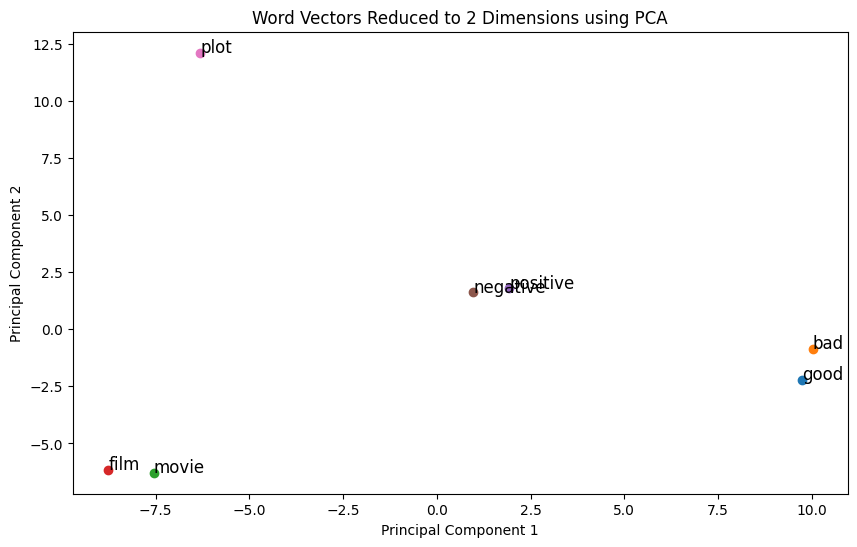

In [ ]:
#dimensionality reduction
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
for word, vector in word_vectors.items():
    print(f"Word: {word}")
    print(f"Vector: {vector}\n")

# Perform PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(list(word_vectors.values()))

# Plot the reduced vectors
plt.figure(figsize=(10, 6))
for word, vector in zip(word_vectors.keys(), reduced_vectors):
    plt.scatter(vector[0], vector[1])
    plt.text(vector[0] + 0.01, vector[1] + 0.01, word, fontsize=12)
plt.title("Word Vectors Reduced to 2 Dimensions using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [ ]:
#reduced dimensions
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
print("2D Vectors:")
for word, vector in zip(word_vectors.keys(), reduced_vectors):
    print(f"Word: {word}, Vector: {vector}")

2D Vectors:
Word: good, Vector: [ 9.73361997 -2.21502593]
Word: bad, Vector: [10.01923791 -0.85215152]
Word: movie, Vector: [-7.55593    -6.28026334]
Word: film, Vector: [-8.77241168 -6.15183234]
Word: positive, Vector: [1.9275188  1.79081848]
Word: negative, Vector: [0.95543263 1.60986529]
Word: plot, Vector: [-6.30746763 12.09858936]


Training Set Evaluation Metrics:
Accuracy: 0.8462
Precision: 0.8426
Recall: 0.8509
F1 Score: 0.8467

Testing Set Evaluation Metrics:
Accuracy: 0.8427
Precision: 0.8373
Recall: 0.8537
F1 Score: 0.8454

The model does not seem to be overfitting.


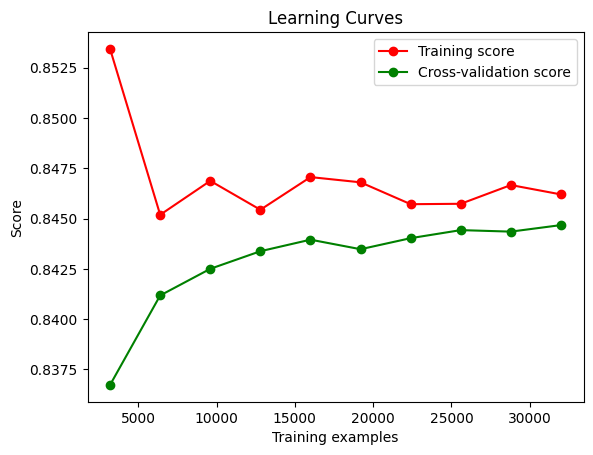

2D Vectors:
Word: good, Vector: [ 9.7336235 -2.215026 ]
Word: bad, Vector: [10.019239  -0.8521473]
Word: movie, Vector: [-7.555931  -6.2802672]
Word: film, Vector: [-8.772413 -6.151833]
Word: positive, Vector: [1.9275177 1.7908177]
Word: negative, Vector: [0.95543116 1.6098633 ]
Word: plot, Vector: [-6.3074727 12.098589 ]


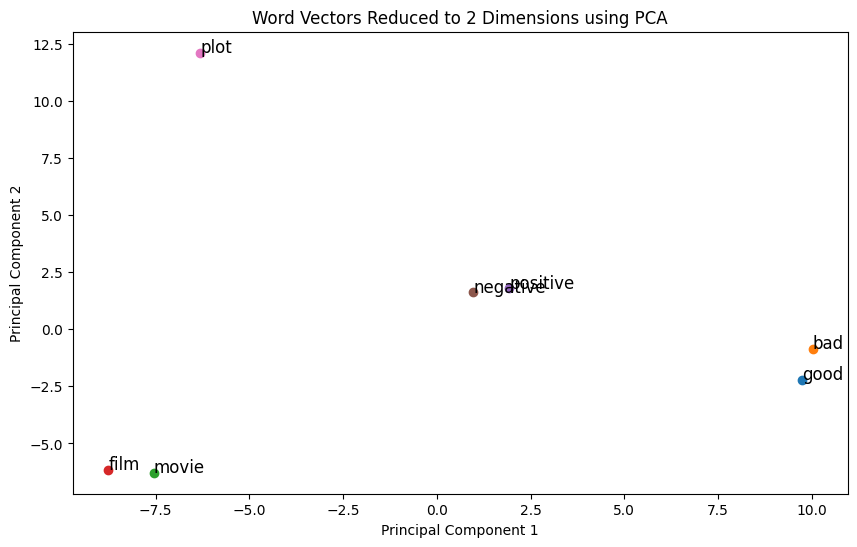

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import re
# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(train_vectors, train_labels)

# Make predictions
train_predictions = model.predict(train_vectors)
test_predictions = model.predict(test_vectors)

# Evaluate the model on the training set
train_accuracy = accuracy_score(train_labels, train_predictions)
train_precision = precision_score(train_labels, train_predictions)
train_recall = recall_score(train_labels, train_predictions)
train_f1 = f1_score(train_labels, train_predictions)

# Evaluate the model on the testing set
test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)

# Print the evaluation metrics
print("Training Set Evaluation Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1 Score: {train_f1:.4f}")

print("\nTesting Set Evaluation Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Check for overfitting
if train_accuracy > test_accuracy + 0.05:  # Adjust the threshold as needed
    print("\nThe model might be overfitting.")
else:
    print("\nThe model does not seem to be overfitting.")

# Plot learning curves
train_sizes, train_scores, test_scores = learning_curve(
    model, train_vectors, train_labels, cv=5, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='accuracy'
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.title('Learning Curves')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend(loc='best')
plt.show()

# Perform PCA to reduce dimensionality to 2
pca = PCA(n_components=2)
word_vectors = np.array(list(word_vectors.values()))
reduced_vectors = pca.fit_transform(word_vectors)

# Print the 2D vectors
print("2D Vectors:")
for word, vector in zip(sample_words, reduced_vectors):
    print(f"Word: {word}, Vector: {vector}")

# Plot the reduced vectors
plt.figure(figsize=(10, 6))
for word, vector in zip(sample_words, reduced_vectors):
    plt.scatter(vector[0], vector[1])
    plt.text(vector[0] + 0.01, vector[1] + 0.01, word, fontsize=12)
plt.title("Word Vectors Reduced to 2 Dimensions using PCA")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [1]:
import numpy as np
import re

# Function to clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)  # Remove special characters
    text = text.lower()  # Lowercase text
    text = text.strip()  # Remove leading and trailing whitespace
    return text

# Function to average Word2Vec vectors for a document
def average_word2vec(tokens, model, num_features):
    feature_vec = np.zeros((num_features,), dtype='float32')
    n_words = 0
    index2word_set = set(model.wv.index_to_key)
    for word in tokens:
        if word in index2word_set:
            n_words += 1
            feature_vec = np.add(feature_vec, model.wv[word])
    if n_words > 0:
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

# Function to predict sentiment
def predict_sentiment(review, w2v_model, logistic_model):
    cleaned_review = clean_text(review)
    tokens = cleaned_review.split()
    review_vector = average_word2vec(tokens, w2v_model, 100)  # Assuming vector_size=100
    review_vector = review_vector.reshape(1, -1)  # Reshape for the model
    prediction = logistic_model.predict(review_vector)
    sentiment = 'positive' if prediction[0] == 1 else 'negative'
    return sentiment

# Example usage
custom_review_1 = "I really enjoyed this movie. The acting was great and the plot was engaging. "
custom_review_2 = "I did not like this movie. It was boring and too long."

sentiment_1 = predict_sentiment(custom_review_1, w2v_model,model)
sentiment_2 = predict_sentiment(custom_review_2, w2v_model,model)

print(f"Review: {custom_review_1}\nSentiment: {sentiment_1}")
print(f"Review: {custom_review_2}\nSentiment: {sentiment_2}")


NameError: name 'w2v_model' is not defined